In [21]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image

from PIL import Image
import numpy as np

import torch
from torchvision import transforms

In [22]:
from diffusers.pipelines.kandinsky2_2.pipeline_kandinsky2_2_img2img import prepare_image, downscale_height_and_width

In [23]:
generator = torch.Generator(device="cuda").manual_seed(42)
output_type = "pil"

# img2img

- stage 1

input: prompt: str, negative_prompt: str

(prompt, negative_prompt) => text_encoder => (prompt_embeds: (4, 1280), text_encoder_hidden_states: (4, 1280))

noise => init_latents: (2, 1280)

(init_latents, prompt_embeds, text_encoder_hidden_states) => diffusion_model => latents: (2, 1280) => chunk

output: embeds: (1, 1280), negative_embeds: (1, 1280)

- stage 2

input: origin_image: (3, 512, 512), embeds: (1, 1280), negative_embeds: (1, 1280)

(origin_image, noise) => init_latents: (4, 64, 64)

(init_latents, embeds, negative_embeds) => diffusion_model => latents: (4, 64, 64)

latent => VQVAE => image: (3, 512, 512)

output: image: (3, 512, 512)

## load pipeline

In [4]:
pipe = AutoPipelineForImage2Image.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder", 
    local_files_only=True,
    torch_dtype=torch.float16
).to('cuda')

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## stage 1

In [25]:
prompt = ''
negative_prompt = None
num_inference_steps: int = 100
guidance_scale: float = 4.0
strength: float = 0.3
num_images_per_prompt: int = 1
height: int = 512
width: int = 512
prior_guidance_scale: float = 4.0
prior_num_inference_steps: int = 25
latents = None

In [26]:
prompt = "A fantasy landscape, Cinematic lighting"
negative_prompt = "low quality, bad quality"

num_inference_steps = 25

In [27]:
with torch.no_grad():

    # process inputs

    if isinstance(prompt, str):
        prompt = [prompt]
    elif not isinstance(prompt, list):
        raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

    if isinstance(negative_prompt, str):
        negative_prompt = [negative_prompt]
    elif not isinstance(negative_prompt, list) and negative_prompt is not None:
        raise ValueError(f"`negative_prompt` has to be of type `str` or `list` but is {type(negative_prompt)}")

    # if the negative prompt is defined we double the batch size to
    # directly retrieve the negative prompt embedding
    if negative_prompt is not None:
        prompt = prompt + negative_prompt
        negative_prompt = 2 * negative_prompt

    device = pipe.prior_pipe._execution_device

    batch_size = len(prompt)
    batch_size = batch_size * num_images_per_prompt

    pipe.prior_pipe._guidance_scale = guidance_scale

    prompt_embeds, text_encoder_hidden_states, text_mask = pipe.prior_pipe._encode_prompt(
        prompt, device, num_images_per_prompt, pipe.prior_pipe.do_classifier_free_guidance, negative_prompt
    )

    # prior
    pipe.prior_pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = pipe.prior_pipe.scheduler.timesteps

    embedding_dim = pipe.prior_pipe.prior.config.embedding_dim

    latents = pipe.prior_pipe.prepare_latents(
        (batch_size, embedding_dim),
        prompt_embeds.dtype,
        device,
        generator,
        latents,
        pipe.prior_pipe.scheduler,
    )
    pipe.prior_pipe._num_timesteps = len(timesteps)
    for i, t in enumerate(pipe.prior_pipe.progress_bar(timesteps)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if pipe.prior_pipe.do_classifier_free_guidance else latents

        predicted_image_embedding = pipe.prior_pipe.prior(
            latent_model_input,
            timestep=t,
            proj_embedding=prompt_embeds,
            encoder_hidden_states=text_encoder_hidden_states,
            attention_mask=text_mask,
        ).predicted_image_embedding

        if pipe.prior_pipe.do_classifier_free_guidance:
            predicted_image_embedding_uncond, predicted_image_embedding_text = predicted_image_embedding.chunk(2)
            predicted_image_embedding = predicted_image_embedding_uncond + pipe.prior_pipe.guidance_scale * (
                predicted_image_embedding_text - predicted_image_embedding_uncond
            )

        if i + 1 == timesteps.shape[0]:
            prev_timestep = None
        else:
            prev_timestep = timesteps[i + 1]

        latents = pipe.prior_pipe.scheduler.step(
            predicted_image_embedding,
            timestep=t,
            sample=latents,
            generator=generator,
            prev_timestep=prev_timestep,
        ).prev_sample

    latents = pipe.prior_pipe.prior.post_process_latents(latents)

    image_embeddings = latents

    # if negative prompt has been defined, we retrieve split the image embedding into two
    if negative_prompt is None:
        zero_embeds = pipe.prior_pipe.get_zero_embed(latents.shape[0], device=latents.device)
    else:
        image_embeddings, zero_embeds = image_embeddings.chunk(2)

    if output_type == "np":
        image_embeddings = image_embeddings.cpu().numpy()
        zero_embeds = zero_embeds.cpu().numpy()

    prior_outputs = (image_embeddings, zero_embeds)

  0%|          | 0/25 [00:00<?, ?it/s]

## stage 2

In [30]:
image = Image.open('./download.png').convert("RGB")
image.thumbnail((768, 768))

In [31]:
with torch.no_grad():
    
    image_embeds = prior_outputs[0]
    negative_image_embeds = prior_outputs[1]

    image = [image] if isinstance(image, Image.Image) else image

    if (
        isinstance(image, (list, tuple))
        and len(image) < image_embeds.shape[0]
        and image_embeds.shape[0] % len(image) == 0
    ):
        image = (image_embeds.shape[0] // len(image)) * image

In [32]:
with torch.no_grad():
    
    device = pipe.decoder_pipe._execution_device

    pipe.decoder_pipe._guidance_scale = guidance_scale

    batch_size = image_embeds.shape[0]

    if pipe.decoder_pipe.do_classifier_free_guidance:
        image_embeds = image_embeds.repeat_interleave(num_images_per_prompt, dim=0)
        negative_image_embeds = negative_image_embeds.repeat_interleave(num_images_per_prompt, dim=0)

        image_embeds = torch.cat([negative_image_embeds, image_embeds], dim=0).to(
            dtype=pipe.decoder_pipe.unet.dtype, device=device
        )

    if not isinstance(image, list):
        image = [image]
    if not all(isinstance(i, (Image.Image, torch.Tensor)) for i in image):
        raise ValueError(
            f"Input is in incorrect format: {[type(i) for i in image]}. Currently, we only support  PIL image and pytorch tensor"
        )

    image = torch.cat([prepare_image(i, width, height) for i in image], dim=0)
    image = image.to(dtype=image_embeds.dtype, device=device)

    latents = pipe.decoder_pipe.movq.encode(image)["latents"]
    latents = latents.repeat_interleave(num_images_per_prompt, dim=0)
    pipe.decoder_pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps, num_inference_steps = pipe.decoder_pipe.get_timesteps(num_inference_steps, strength, device)
    latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)
    height, width = downscale_height_and_width(height, width, pipe.decoder_pipe.movq_scale_factor)
    latents = pipe.decoder_pipe.prepare_latents(
        latents, latent_timestep, batch_size, num_images_per_prompt, image_embeds.dtype, device, generator
    )
    pipe.decoder_pipe._num_timesteps = len(timesteps)
    for i, t in enumerate(pipe.decoder_pipe.progress_bar(timesteps)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if pipe.decoder_pipe.do_classifier_free_guidance else latents

        added_cond_kwargs = {"image_embeds": image_embeds}
        noise_pred = pipe.decoder_pipe.unet(
            sample=latent_model_input,
            timestep=t,
            encoder_hidden_states=None,
            added_cond_kwargs=added_cond_kwargs,
            return_dict=False,
        )[0]

        if pipe.decoder_pipe.do_classifier_free_guidance:
            noise_pred, variance_pred = noise_pred.split(latents.shape[1], dim=1)
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            _, variance_pred_text = variance_pred.chunk(2)
            noise_pred = noise_pred_uncond + pipe.decoder_pipe.guidance_scale * (noise_pred_text - noise_pred_uncond)
            noise_pred = torch.cat([noise_pred, variance_pred_text], dim=1)

        if not (
            hasattr(pipe.decoder_pipe.scheduler.config, "variance_type")
            and pipe.decoder_pipe.scheduler.config.variance_type in ["learned", "learned_range"]
        ):
            noise_pred, _ = noise_pred.split(latents.shape[1], dim=1)

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.decoder_pipe.scheduler.step(
            noise_pred,
            t,
            latents,
            generator=generator,
        )[0]


  0%|          | 0/7 [00:00<?, ?it/s]

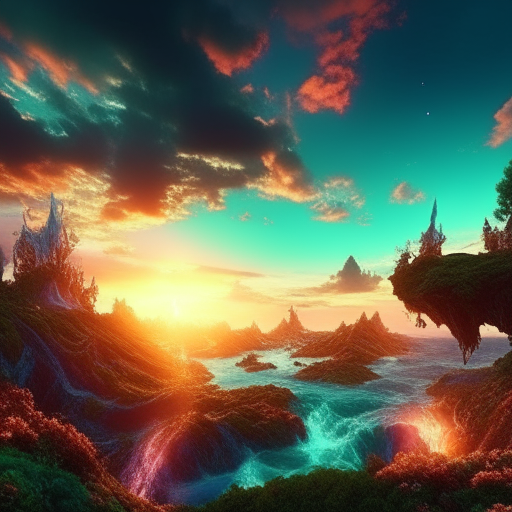

In [33]:
with torch.no_grad():

    if not output_type == "latent":
        # post-processing
        image = pipe.decoder_pipe.movq.decode(latents, force_not_quantize=True)["sample"]
        if output_type in ["np", "pil"]:
            image = image * 0.5 + 0.5
            image = image.clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).float().numpy()

        if output_type == "pil":
            image = pipe.decoder_pipe.numpy_to_pil(image)

image[0]